In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test_ids = test_df['Id'].copy()
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Fill in missing values

In [3]:
missing = train_df.isnull().sum()
missing_cols = missing[missing > 0]
print(missing_cols.sort_values(ascending = False))

missing = test_df.isnull().sum()
missing_cols = missing[missing > 0]
print('\n',missing_cols.sort_values(ascending = False))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

 PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageCars         1
GarageArea         1
TotalBsmtSF        1
KitchenQual        1
BsmtUnfSF          

In [4]:
#fill in missing cols with none

cols_fill_none = ['Alley', 'PoolQC', 'Fence', 'FireplaceQu', 
                  'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                  'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageYrBlt', 'MasVnrType']

for df in [train_df, test_df]:
    for col in cols_fill_none:
        df[col] = df[col].fillna('None')

In [5]:
# Fill in null vals < 50 for train
null_val_less_50 = train_df.isnull().sum()
null_val_less_50 = null_val_less_50[null_val_less_50 < 50]
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = train_df.select_dtypes(include=['object']).columns

for col in null_val_less_50.index:
    if col in num_cols:
        train_df[col] = train_df[col].fillna(train_df[col].mean())
    elif col in cat_cols:
        train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

# Fill in null vals < 50 for test
null_val_less_50 = test_df.isnull().sum()
null_val_less_50 = null_val_less_50[null_val_less_50 < 50]
num_cols = test_df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = test_df.select_dtypes(include=['object']).columns

for col in null_val_less_50.index:
    if col in num_cols:
        test_df[col] = test_df[col].fillna(test_df[col].mean())
    elif col in cat_cols:
        test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

In [6]:
missing = train_df.isnull().sum()
missing_cols = missing[missing > 0]
print(missing_cols.sort_values(ascending = False))

missing = test_df.isnull().sum()
missing_cols = missing[missing > 0]
print('\n',missing_cols.sort_values(ascending = False))

MiscFeature    1406
LotFrontage     259
dtype: int64

 MiscFeature    1408
LotFrontage     227
dtype: int64


# Feature engineering

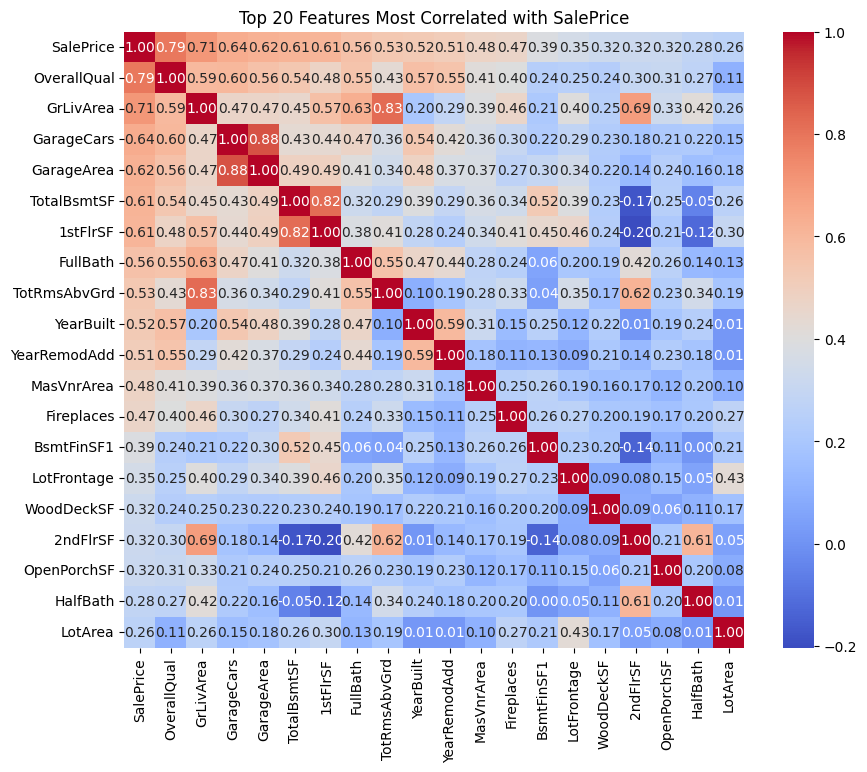

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# pick numeric features only
numeric_df = train_df.select_dtypes(include=['number'])

# correlation matrix
corr = numeric_df.corr()

# sort top correlations with SalePrice
top_corr = corr["SalePrice"].sort_values(ascending=False).head(20)

# plot heatmap of the most correlated ones
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df[top_corr.index].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Top 20 Features Most Correlated with SalePrice")
plt.show()

In [8]:
# Map quality columns
quality_map = {
    "Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1
}
quality_cols = [
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond",
    "KitchenQual", "HeatingQC", "GarageQual", "GarageCond", "PoolQC"
]

for df in [train_df, test_df]:
    for col in quality_cols:
        if col in df.columns:
            df[col] = df[col].map(quality_map).fillna(0)

In [9]:
# Feature engineering - grouped quality features
# Interior
train_df["overall_interior_quality"] = train_df[["OverallQual", "OverallCond", "KitchenQual"]].mean(axis=1)
test_df["overall_interior_quality"] = test_df[["OverallQual", "OverallCond", "KitchenQual"]].mean(axis=1)

# Exterior
train_df["overall_exterior_quality"] = train_df[["ExterQual", "ExterCond"]].mean(axis=1)
test_df["overall_exterior_quality"] = test_df[["ExterQual", "ExterCond"]].mean(axis=1)

# Basement
train_df["overall_basement_quality"] = train_df[["BsmtQual", "BsmtCond"]].mean(axis=1)
test_df["overall_basement_quality"] = test_df[["BsmtQual", "BsmtCond"]].mean(axis=1)

# Garage
train_df["garage_overall"] = train_df[["GarageQual", "GarageCond"]].mean(axis=1)
test_df["garage_overall"] = test_df[["GarageQual", "GarageCond"]].mean(axis=1)

# Outdoor
train_df["overall_outdoor_quality"] = train_df[["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea"]].sum(axis=1)
test_df["overall_outdoor_quality"] = test_df[["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea"]].sum(axis=1)

In [10]:
cat_cols = train_df.select_dtypes(include=['object', 'category']).columns

for df in [train_df, test_df]:
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype(str)

# Splitting

In [11]:
#drop
for df in [train_df, test_df]:
    df.drop(['PoolQC', 'Fence', 'MiscFeature', 'Alley'], axis=1, inplace=True, errors='ignore')

In [12]:
X = train_df.drop(['SalePrice'], axis=1)
y = train_df['SalePrice']

X_test = test_df.copy()

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

y_binned = pd.qcut(y, q=10, duplicates='drop')
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_i, val_i in split.split(X, y_binned):
    X_train, X_val = X.iloc[train_i], X.iloc[val_i]
    y_train, y_val = y.iloc[train_i], y.iloc[val_i]

# encoding

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='drop'
)

In [15]:
from lightgbm import LGBMRegressor

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        random_state=0
    ))
])


In [16]:
from sklearn.metrics import mean_squared_error

model.fit(X_train, y_train)

predicts = model.predict(X_val)

rmse = mean_squared_error(y_val, predicts, squared=False)
print(f'validation: {rmse:.4f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3675
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 181
[LightGBM] [Info] Start training from score 180976.886130
validation: 28498.0758


In [17]:
test_predict = model.predict(X_test)

In [18]:
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': test_predict
})
submission.to_csv('submission.csv', index=False)
print("\nSubmission file created successfully!")


Submission file created successfully!
